In [2]:
import os
import pickle
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from mtcnn import MTCNN
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

2024-03-02 14:30:52.832179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Image Preprocessing and Data Preperation
Face Detection
Image Cropping, Alignment and Grayscaling
Rescaling and Padding
224,224,3 grayscale images as expected by the pretrained models

This code only needs to be run once to create the dataset used for training.

In [ ]:
# Initialize MTCNN detector
detector = MTCNN()

base_dir = "Datasets/combined_dataset_faces_only_mtcnn"
processed_folder = "Datasets/combined_dataset_processed_224_3"

# Emotion classes
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Create directories for the new dataset
if not os.path.exists(processed_folder):
    os.makedirs(processed_folder)
for emotion in emotions:
    os.makedirs(os.path.join(processed_folder, emotion), exist_ok=True)

target_width, target_height = 224, 224

for emotion in emotions:
    emotion_dir = os.path.join(base_dir, emotion)
    all_images = os.listdir(emotion_dir)
    existing_dir = os.path.join(processed_folder, emotion)
    existing_images = os.listdir(existing_dir)
    all_images = [img for img in all_images if img not in existing_images]

    for image_name in all_images:
        try:
            img_path = os.path.join(emotion_dir, image_name)
            # Load an image
            img = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Detect faces in the image
            results = detector.detect_faces(image_rgb)
            
            if results:
                # Extract the bounding box and facial landmarks
                x, y, width, height = results[0]['box']
                landmarks = results[0]['keypoints']
                
                # Calculate the angle to align eyes horizontally
                left_eye = landmarks['left_eye']
                right_eye = landmarks['right_eye']
                delta_x = right_eye[0] - left_eye[0]
                delta_y = right_eye[1] - left_eye[1]
                angle = np.arctan(delta_y / delta_x) * 180 / np.pi
                
                # Center coordinates of the face
                center = (x + width // 2, y + height // 2)
                # Rotation matrix
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
                # Perform the rotation on the entire image
                aligned_image = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
                # Crop the face
                aligned_face = aligned_image[y:y + height, x:x + width]
                # Convert to grayscale
                aligned_face_gray = cv2.cvtColor(aligned_face, cv2.COLOR_BGR2GRAY)
                
                # Convert the aligned grayscale face to PIL Image for resizing and padding
                pil_image = Image.fromarray(aligned_face_gray)
                
                # Calculate the scaling factor to maintain aspect ratio
                aspect_ratio = min(target_width / pil_image.width, target_height / pil_image.height)
                new_width = int(pil_image.width * aspect_ratio)
                new_height = int(pil_image.height * aspect_ratio)
                # Resize the image with the scaling factor
                pil_image = pil_image.resize((new_width, new_height), Image.LANCZOS)
                
                # Create a new image with padding
                new_image = Image.new("L", (target_width, target_height), (0))
                paste_position = ((target_width - new_width) // 2, (target_height - new_height) // 2)
                new_image.paste(pil_image, paste_position)
                
                # Convert the single-channel grayscale image to 3-channel
                new_image_rgb = new_image.convert("RGB")
                
                save_path = os.path.join(processed_folder, emotion, image_name)
                new_image_rgb.save(save_path)
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")


1/1 [==============================] - 0s 31ms/step


# Data Preperation

In [11]:
# Define paths to your training and testing directories
data_dir = 'Datasets/combined_dataset_processed'

# Function to add images from a directory to a list
def process_directory(directory, data_list):
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)

        # Check if it's a directory
        if os.path.isdir(class_dir):
            # Loop through each image in the folder
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                # processed_image_path = image_path.replace('combined_dataset_deepface', 'combined_dataset_processed')
                # Append to the data list
                data_list.append({'filepath': image_path, 'label': class_name})

# Initialize an empty list for storing data
data_list = []
# Add training images to the data list
process_directory(data_dir, data_list)
# Create a DataFrame from the list
df = pd.DataFrame(data_list)
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
# Print the amount of images per category before balancing
print("Images per category:")
print(df['label'].value_counts())

# # Determine the label with the least amount of images
# min_label_count = df['label'].value_counts().min()
# # Reduce all categories to this size by randomly removing entries
# balanced_df = df.groupby('label').sample(n=min_label_count, random_state=42).reset_index(drop=True)
# # Optionally, shuffle the DataFrame again to ensure mixed labels
# balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
# # Print 15 random samples of the balanced DataFrame
# print(balanced_df.sample(15))
# # Print the amount of images per category after balancing
# print("\nImages per category after balancing:")
# print(balanced_df['label'].value_counts())

Images per category:
label
happy       17299
neutral     12928
sad         11161
angry        9415
surprise     9302
fear         8649
disgust      4767
Name: count, dtype: int64


# Preprocessing

In [30]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# Set the image size and batch size
image_size = (224, 224) # Can be increased to improve accuracy or decreased to improve speed. (48, 48) for FER2013, (224, 224) for RAF-DB
batch_size = 64

# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)  # 80% training, 20% test
train_df, val_df = train_test_split(train_df, test_size=0.11, random_state=42)  # Of the 80% training, split into 60% training and 20% validation

# Calculate and print split ratios
total_samples = len(df)
train_ratio = len(train_df) / total_samples
val_ratio = len(val_df) / total_samples
test_ratio = len(test_df) / total_samples

print(f"Total samples: {total_samples}")
print(f"Training set: {train_ratio:.2f} ({len(train_df)} samples)")
print(f"Validation set: {val_ratio:.2f} ({len(val_df)} samples)")
print(f"Test set: {test_ratio:.2f} ({len(test_df)} samples)\n")

def convert_to_rgb(image):
    return np.repeat(image, 3, axis=-1)

# Create an ImageDataGenerator for data augmentation (optional)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    # rotation_range=15,  # rotation. Not needed since all images are getting aligned
    width_shift_range=0.05, # horizontal shift (only 5% since faces are centered)
    height_shift_range=0.05, # vertical shift (only 5% since faces are centered)
    shear_range=0.1, 
    # zoom_range=0.1,   zoom (with current dataset not needed, since faces are centered)
    horizontal_flip=True, # flip images horizontally
    fill_mode='constant', # fill in missing pixels (nearest / constant)
    # brightness_range=[0.8, 1.2] # darken and lighten images
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation data
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test data

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    preprocessing_function=preprocess_input,
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
# Assuming 'labels' contains your class labels for the training data
labels = train_df['label'].values
unique_classes = np.unique(labels)
# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=unique_classes, y=labels)
# Get class indices from the generator
class_indices = train_generator.class_indices
# Ensure the order of `unique_classes` matches the order in `class_indices`
ordered_unique_classes = sorted(unique_classes, key=lambda x: class_indices[x])
# Create a dictionary mapping class indices to their weights
class_weights_dict = {class_indices[label]: weight for label, weight in zip(ordered_unique_classes, class_weights)}
print(class_weights_dict)

Total samples: 73521
Training set: 0.80 (58889 samples)
Validation set: 0.10 (7279 samples)
Test set: 0.10 (7353 samples)
Found 58889 validated image filenames belonging to 7 classes.
Found 7279 validated image filenames belonging to 7 classes.
Found 7353 validated image filenames belonging to 7 classes.
{0: 1.1150052068541134, 1: 2.1845531772823383, 2: 1.2194106806369454, 3: 0.6065840569409681, 4: 0.8151065096128559, 5: 0.9369322068954544, 6: 1.133025493025493}


# Image before and after preprocessing comparison

In [20]:
# Create a non-preprocessing ImageDataGenerator
no_preprocessing_datagen = ImageDataGenerator()

# Create a temporary generator to fetch a batch of original images
temp_generator = no_preprocessing_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Keep the same order as the original generator
)

# Function to plot images in a grid
def plot_images_before(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype('uint8'))  # Cast to uint8 for correct image display
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch a batch of original images
original_batch = next(temp_generator)
original_images = original_batch[0][:25]  # Select first 25 images

# Function to plot images in a grid
def plot_images_after(images_arr):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray')  # Set the colormap to 'gray'
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images
example_batch = next(train_generator)
example_images = example_batch[0][:25]  # Select first 25 images

# Plot the images
# plot_images_before(original_images)
# plot_images_after(example_images)

Found 38158 images belonging to 4 classes.


## ResNet50V2
ResNet50V2 expects 224x224 input

In [34]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
# Load the ResNet50V2 model without the top layer
base_model = ResNet50V2(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
# model.summary()

## VGG-16

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model, pre-trained on ImageNet
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers for FER
x = base_model.output
x = Flatten()(x)  # Flatten the output layer to 1 dimension
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Compile the model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
# model_vgg16.summary()

## MobileNetV2

In [42]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

# Freeze the layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers for FER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Compile the model
model_mobilenetv2 = Model(inputs=base_model.input, outputs=predictions)
model_mobilenetv2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

# EfficientNetB0

In [43]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the EfficientNetB0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/efficientnetb0_notop.h5')

# Freeze the layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers for FER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Compile the model
model_efficientnetb0 = Model(inputs=base_model.input, outputs=predictions)
model_efficientnetb0.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Exception: URL fetch failure on https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

# DenseNet121

In [46]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('PretrainedModels/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom top layers for FER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 emotions

# Compile the model
model_densenet121 = Model(inputs=base_model.input, outputs=predictions)
model_densenet121.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

# Callbacks

In [7]:
# Early stopping to prevent overfitting. This stops training when the model's performance on the validation set starts to degrade.
early_stopper = EarlyStopping(
    monitor='val_loss',  # Metric to be monitored
    patience=3,         # Number of epochs with no improvement after which training will be stopped. Reduced from 10
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

# Create a ModelCheckpoint callback
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
checkpoint = ModelCheckpoint(
    f'logs/model_checkpoint_{timestamp}.keras',  # Path where to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=False,    # Save only the best model. Set False to save the model at the end of every epoch so restarting from specific epoch is possible
    save_weights_only=False, # Save only the weights
    mode='min',             # Minimize the monitored metric (val_loss) min before
    verbose=1               # Verbose output
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001,
    cooldown=3,
    verbose=1
)

# Model Training

In [50]:
# Load the last saved weights
# model.load_weights('logs/model_checkpoint_20240225_085054.keras')

epochs = 30 # When resuming training, set epochs to the total number of epochs you want to train, not just the additional epochs. The model.fit() method continues training for the specified number of epochs, starting from the current epoch count. Typically, 10 to 100 epochs are used. Start with e.g. 30-50.

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights_dict
    # callbacks=[early_stopper, checkpoint]
)

# Save the training history for later analysis
with open(f'logs/training_history_{timestamp}.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/30
  4/920 [..............................] - ETA: 27:33 - loss: 2.1948 - accuracy: 0.3125

KeyboardInterrupt: 

# Evaluation and Visualization

76/76 [==============================] - 24s 304ms/step - loss: 1.1121 - accuracy: 0.6758
Test accuracy:  0.6757877469062805
76/76 [==============================] - 23s 300ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.58      0.62      0.60       479
     disgust       0.27      0.87      0.41        60
        fear       0.57      0.31      0.40       577
       happy       0.89      0.82      0.86      1584
     neutral       0.58      0.81      0.67       908
         sad       0.60      0.45      0.51       705
    surprise       0.68      0.74      0.71       511

    accuracy                           0.68      4824
   macro avg       0.60      0.66      0.60      4824
weighted avg       0.69      0.68      0.67      4824

Weighted Precision: 0.6920334151766832
Weighted Recall: 0.675787728026534
Weighted F1-Score: 0.6715567093253572


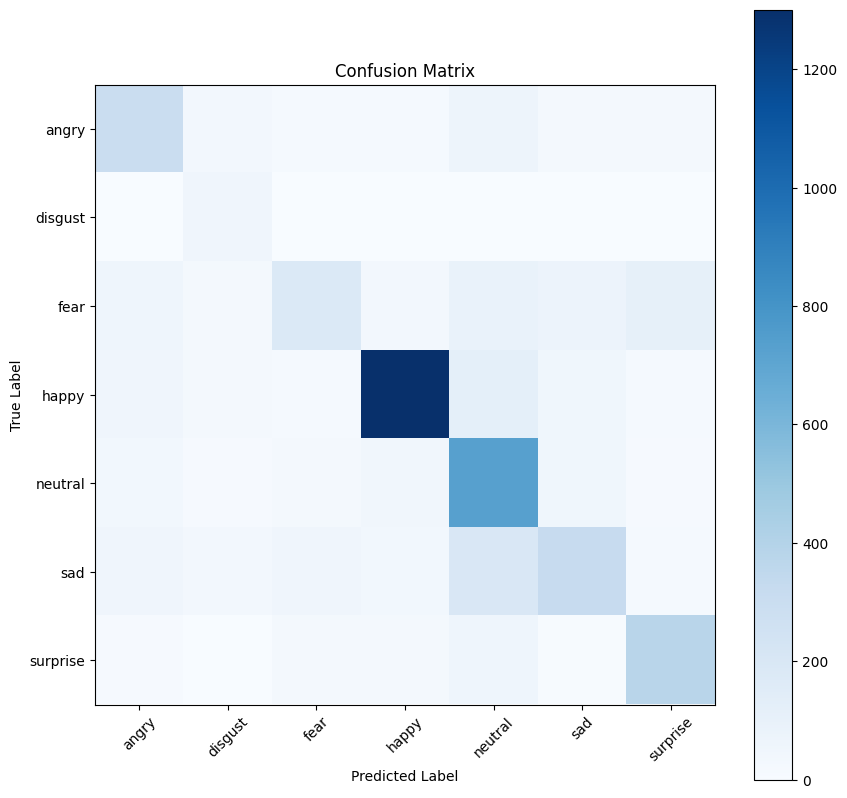

In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
print("Test accuracy: ", test_accuracy)

# Predictions on the test set
test_generator.reset() # Ensuring the generator is reset to the beginning
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1) # Convert predictions to class labels

# Since the generator omits some samples due to rounding down in 'steps', we trim 'true_classes' to match 'predicted_classes' length
true_classes = test_generator.classes
true_classes = true_classes[:len(predicted_classes)]

class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0))

# Additional weighted metric calculations
weighted_precision = precision_score(true_classes, predicted_classes, average='weighted')
weighted_recall = recall_score(true_classes, predicted_classes, average='weighted')
weighted_f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1-Score:", weighted_f1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Conducting error analysis
This can be done by examining misclassified examples, which can provide insights into what types of errors the model is making

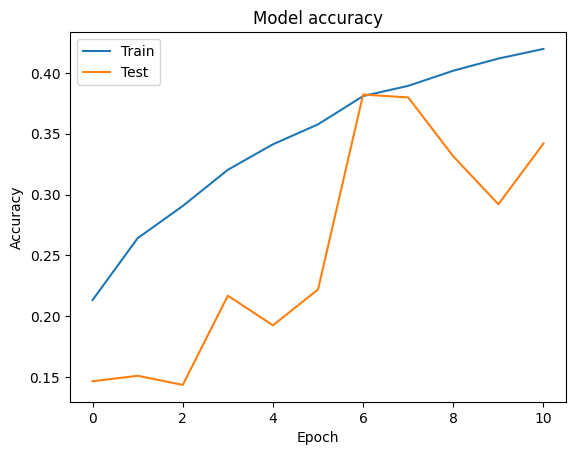

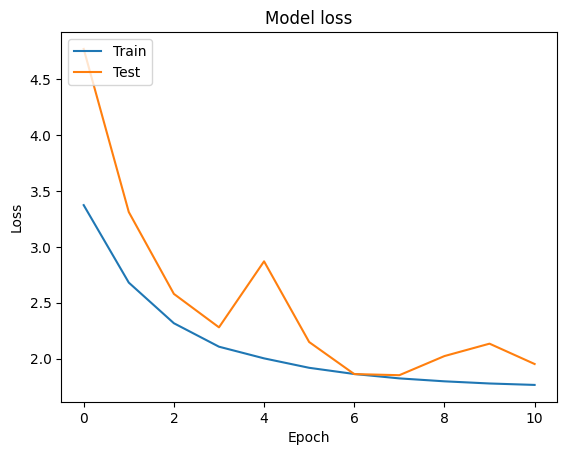

In [16]:
# Learning Curves
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

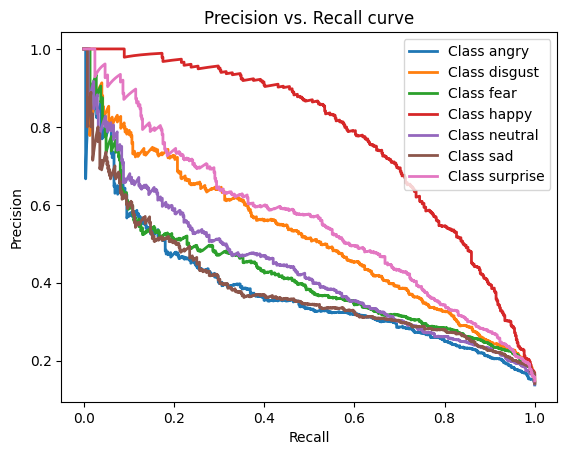

In [30]:
# Precsion-Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class
y_bin = label_binarize(true_classes, classes=np.arange(len(class_labels)))
n_classes = y_bin.shape[1]

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], predictions[:, i])

# Plot the precision-recall curve
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(class_labels[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

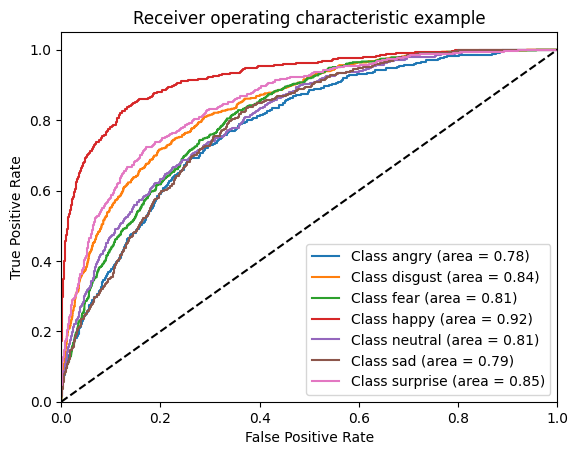

In [31]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()